In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

In [3]:
df = pd.read_csv(r'C:\Users\krish\Music\Job_ML_project\data\data_prepared_check.csv')

In [4]:
import pickle
file = open("./utils/skill_dictionary",'rb')
skills_dict = pickle.load(file)
file.close()

In [5]:
df.head()

,Job_position,Company,Location,requirements,rating,experience,posting_frequency,avg_yearly_sal,income_cat,net_experience,...,algorithms,architecture,source,information,bootstrap,mysql,debugging,restful,apis,linux
0,na,Gather Network,"Urban Estate Gurgaon, Haryana",blockchain,0.0,na,1.0,240000.0,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,na,Agile Placement,"Pune, Maharashtra",java spark python r,0.0,Total work: 6 years,1.0,950000.0,4,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,na,Client of PlaceElements HR,"Thiruvananthapuram, Kerala",NaN,0.0,Python: Algorithms: Statistics: 1 yearData Sci...,1.0,750000.0,4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,na,Siemens Technology and Services Private Limited,"Pune, Maharashtra",c++,4.0,na,2.0,0.0,-1,-99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,na,Teqlinx Software Solutions LLC,"Bengaluru, Karnataka",structures,0.0,na,1.0,3000000.0,6,-99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets start with salary

<AxesSubplot:xlabel='avg_yearly_sal', ylabel='Count'>

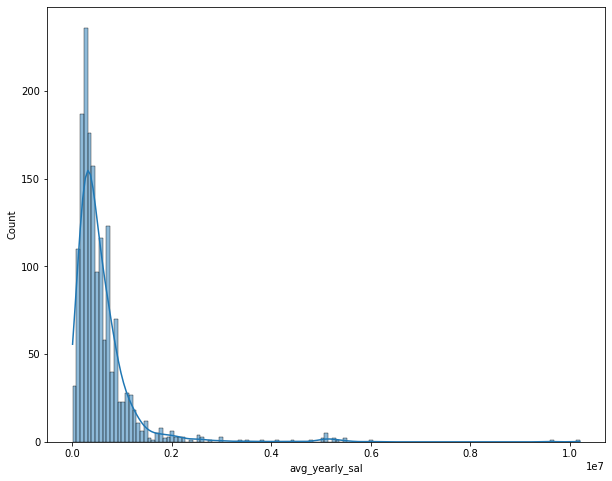

In [6]:
sns.histplot(df.loc[(df['avg_yearly_sal'] != 0)]['avg_yearly_sal'], kde=True)

Clearly the salary distribution is not uniform with most annual salries below Rs.1000000 and a few high salaries  

Lets calculate the typical salary one is likely to get out there annualy

In [7]:
# median not mean as distribution is skewed 
df['avg_yearly_sal'].median()

186000.0

Uhh.. not very soothing :( 

Lots of outliers in our dataset, lets try to deal with it

In [8]:
# removing values that fall below 5 and above 95 percentile
max_val = df.avg_yearly_sal.quantile(0.95)
min_val = df.avg_yearly_sal.quantile(0.05)
quantile_df = df[(df['avg_yearly_sal']>min_val) & (df['avg_yearly_sal']<max_val)]
len(quantile_df)

1478

Nope loosing a lot of data 

In [9]:
# lets try with iqr with replacing values Q1 that fall_below lower limit and Q2 that are above upper limit
Q1 = df.avg_yearly_sal.quantile(0.25)
Q3 = df.avg_yearly_sal.quantile(0.75)
IQR = Q3-Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

quantile_df = df.copy()
quantile_df['avg_yearly_sal'] = np.where(df['avg_yearly_sal']>upper_limit,upper_limit,df['avg_yearly_sal'])
quantile_df['avg_yearly_sal'] = np.where(df['avg_yearly_sal']<lower_limit,lower_limit,df['avg_yearly_sal'])

<AxesSubplot:xlabel='avg_yearly_sal'>

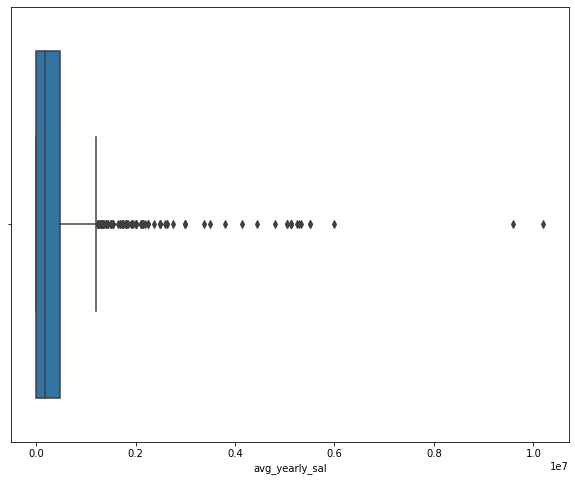

In [10]:
sns.boxplot(x= 'avg_yearly_sal', data=quantile_df)

This doesnt help either <br>
Lets just keep all the data for now <br>
Lets now look at the boxplot of salary distribution of our orignal dataframe

<AxesSubplot:xlabel='avg_yearly_sal'>

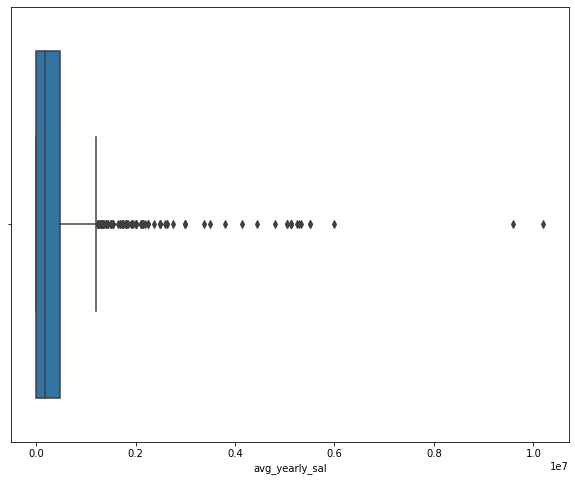

In [11]:
sns.boxplot(x='avg_yearly_sal', data=df)

<AxesSubplot:xlabel='income_cat', ylabel='Count'>

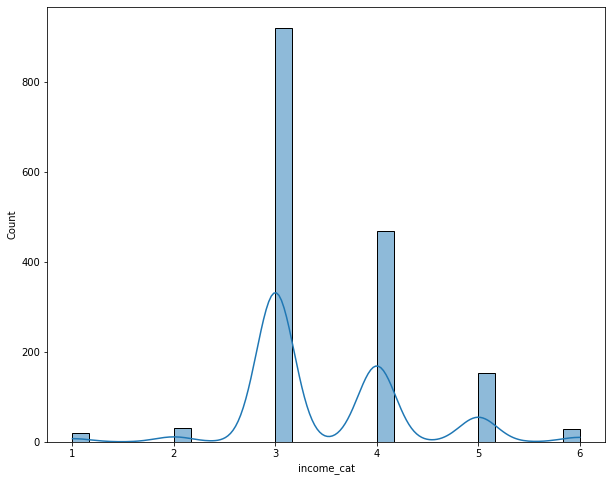

In [12]:
sns.histplot(x = 'income_cat', data=df[df['income_cat'] > 0], kde = True)

Most annual incomes are in the range of 1 to 5 lpa 

As observed from the <b>income category</b> distribution and the <b>avg_annual_sal</b> distribution the salary distribution is really skewed, as most of the people are payed near the average which is pretty low and only a few people get really high salaries 

Now lets continue with EDA <br>

In [13]:
corr = df[['Job_position', 'posting_frequency', 'avg_yearly_sal', 'rating', 'net_experience', 'bachelor', 'masters', 'secondary', 'job_title', 'jr',
       'senior', 'popular_profession', 'data scientist', 'deep learning', 'machine learning', 'software developer', 'software engineer',
       'job_openings', 'job_descr_len']].corr()

<AxesSubplot:>

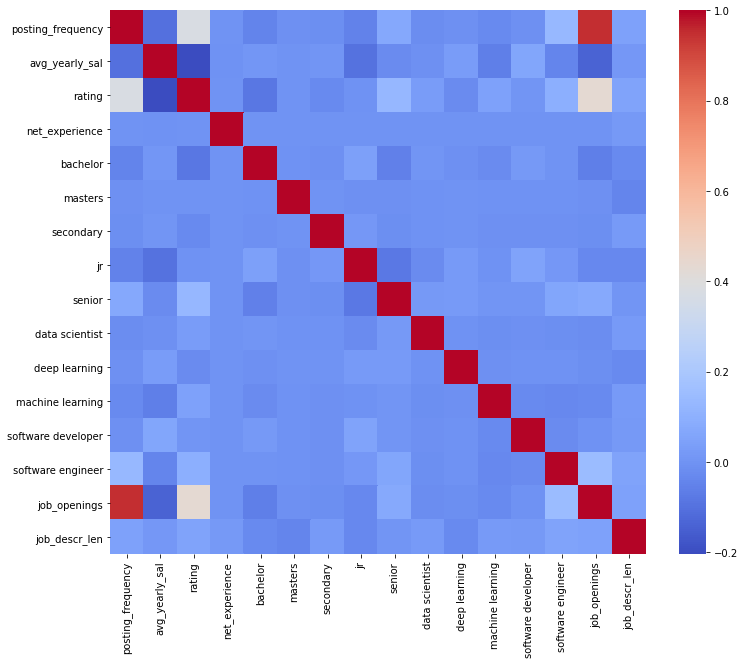

In [14]:
plt.figure(figsize=(12,10))
plt.figure
sns.heatmap(corr, cmap='coolwarm')

We can get a lot of information from this heatmap : <br>
(i) <b>Average year salary</b> and <b>net experience</b> are slightly positively correlated, which is expected, as companies offer higher annual salary to more experienced employees. <br>
(ii) <b>Average year salary</b> and <b>rating</b> are slightly negatively correlated, which is interesting, companies which higher ratings offer lower annual salary. <br>
(iii) There is also a slight <b>negative correlation</b> between <b>jr</b> title and <b>avg_year_salary</b> which is expected, but its intersting for <b>machine leaning</b> and <b>average annual salary</b> considering <b>ML</b> is such a hot topic in the job market around the world. <br>

most of other columns are weakly corelated 

Lets look at avg salary vs net experience

Code for displaying values above bars taken from this post ( https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values ) 

In [15]:
df['net_experience'] = df['net_experience'].replace(to_replace=[-990, -990000, 2000], value=-99)

In [16]:
freq = df.groupby(['net_experience'])['avg_yearly_sal'].median()
freq = freq[freq>0]
freq = pd.DataFrame([freq.index, freq.values]).T
freq.columns = ['net_experience','avg_yearly_sal']

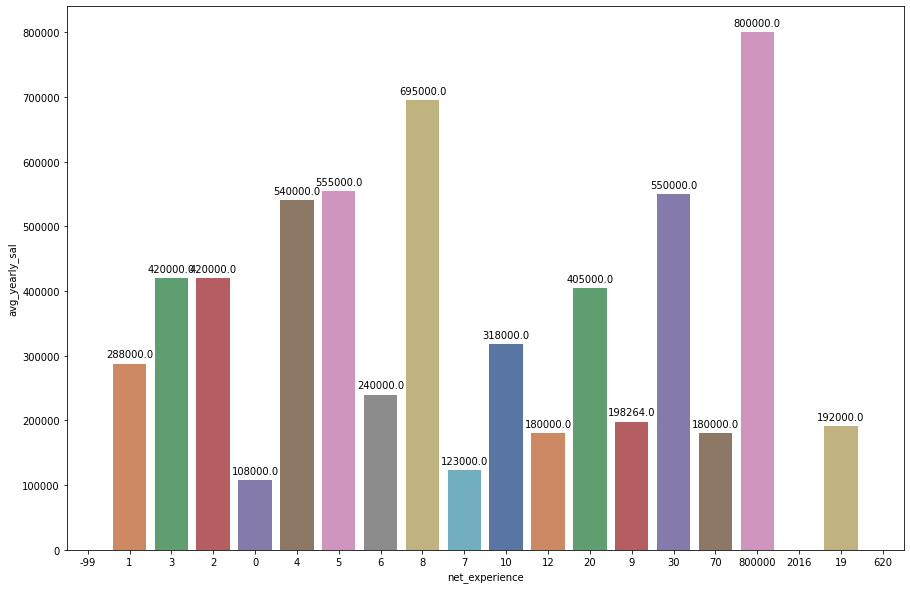

In [17]:
plt.figure(figsize = (15,10))
splot = sns.barplot(x='net_experience', y='avg_yearly_sal', data=freq, palette='deep', order=df['net_experience'].value_counts().index)
for p in splot.patches:
                  splot.annotate(format(p.get_height(), '.1f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 9), 
                  textcoords = 'offset points')    

As expected companies tend to pay more to the more experienced employess <br>

Lets now look at average yearly salary wrt ratings

In [18]:
freq = df.groupby(['rating'])['avg_yearly_sal'].median()
freq = freq[freq>0]
freq = pd.DataFrame([freq.index, freq.values]).T
freq.columns = ['ratings','avg_yearly_sal']

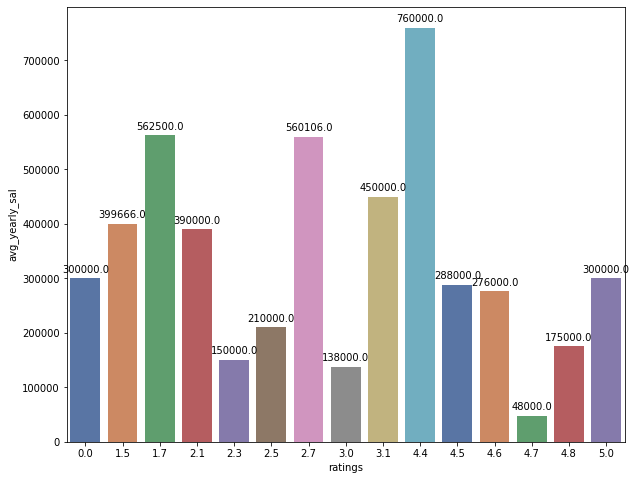

In [19]:
splot = sns.barplot(x='ratings', y='avg_yearly_sal', data=freq, palette='deep' )
for p in splot.patches:
                  splot.annotate(format(p.get_height(), '.1f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 9), 
                  textcoords = 'offset points')    

From above plot we can see that: <br>
(i) distribution is not uniform <br>
(ii) looks like companies higher rated companies tend to offer lower annual salaries <br>
***Note:***  0 ratings are for companies missing ratings 

Now, lets look at the effect of <b>seniority</b> on your salary <br>

<AxesSubplot:xlabel='job_title', ylabel='avg_yearly_sal'>

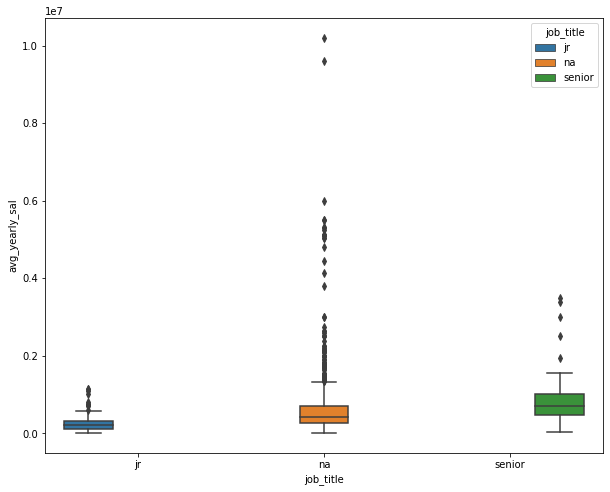

In [20]:
sns.boxplot(x='job_title', y='avg_yearly_sal', data = df[df['avg_yearly_sal'] != 0], hue = 'job_title')

As expected candidates for senior job titles are paid higher,  <br>
Also, it looks like most of the missing values are of type senior as it has a lot of outliers

lets look at the states for job postings

<AxesSubplot:xlabel='count', ylabel='State'>

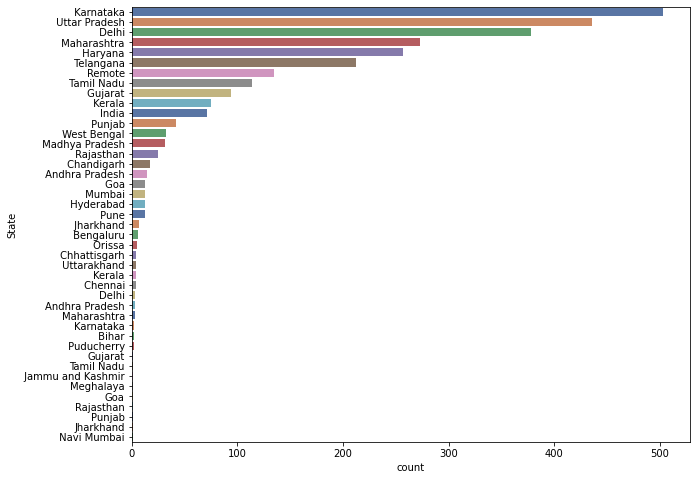

In [21]:
# Looks like Delhi has the most job openings 
sns.countplot(y="State", data = df, palette='deep', order = df['State'].value_counts().index)

Most job openings are in Delhi, followed by Uttar Pradesh

Lets now look at the avg year salary vs State w.r.t seniority 

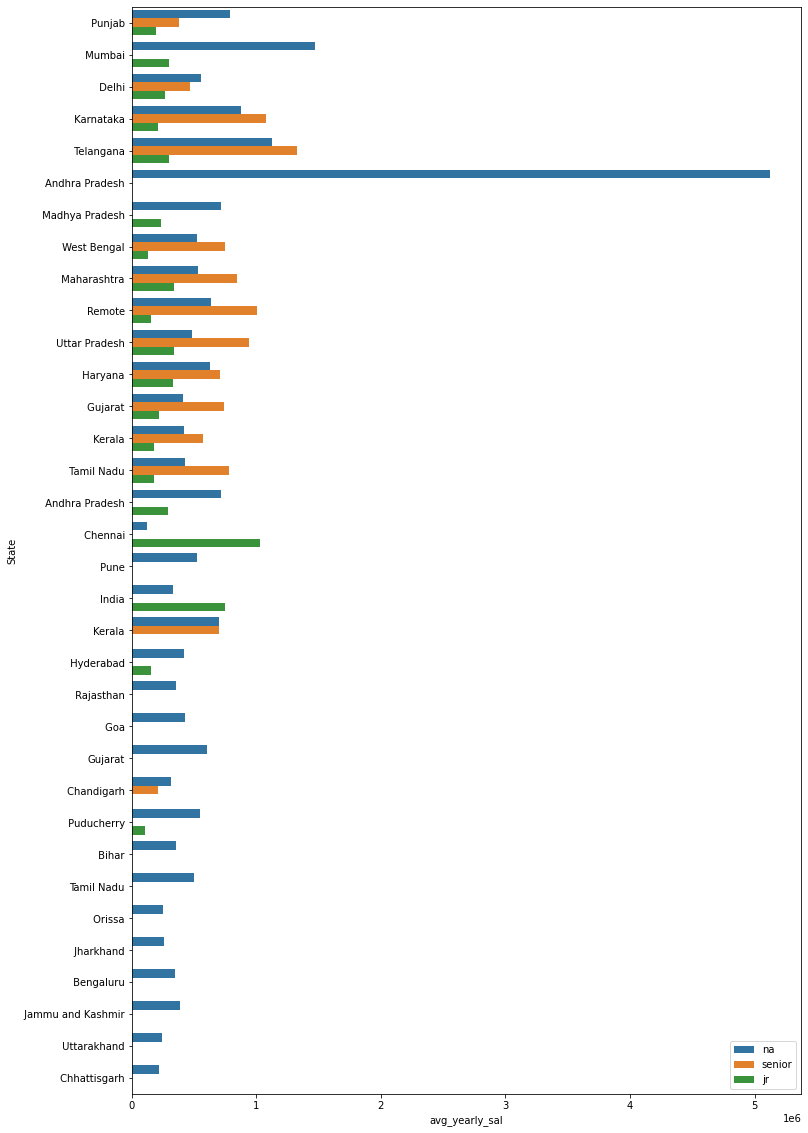

In [22]:
plt.figure(figsize=(12,20))
pd_df = df.sort_values('avg_yearly_sal',ascending=False).reset_index()
sns.barplot(x='avg_yearly_sal', y='State', data=pd_df.loc[(pd_df['avg_yearly_sal'] != 0)], ci=False, hue='job_title') 
plt.legend(loc='lower right')

lets now look at the skill dictionary that we generated during feature engineering <br>
It contains the <b>frequency</b> of a particular skill occuring in <b>requirements</b> column

In [23]:
skill_df = pd.DataFrame.from_dict(skills_dict, orient='index', columns=['Frequency'])

top_skills = skill_df.sort_values(by='Frequency', ascending=False)[:10]
top_skills['skills'] = top_skills.index
top_skills.set_index(np.arange(0,len(top_skills)), inplace=True)

In [24]:
skill_df['skills'] = skill_df.index
skill_df.set_index(np.arange(0, len(skill_df)), inplace=True)

In [25]:
skill_df['States'] = df['State']

Now lets look at top 10 skills in demand by companies 

In [26]:
top_10 = pd.pivot_table(df[(df['Job_position'] != 'na') & (df['avg_yearly_sal'] != 0)], index=['Company', 'Job_position', 'job_title'], values=['avg_yearly_sal'] )

In [27]:
top_10.reset_index(inplace=True)

In [28]:
top_10 = top_10.sort_values(by='avg_yearly_sal', ascending=False)[:10]

<AxesSubplot:xlabel='avg_yearly_sal', ylabel='Company'>

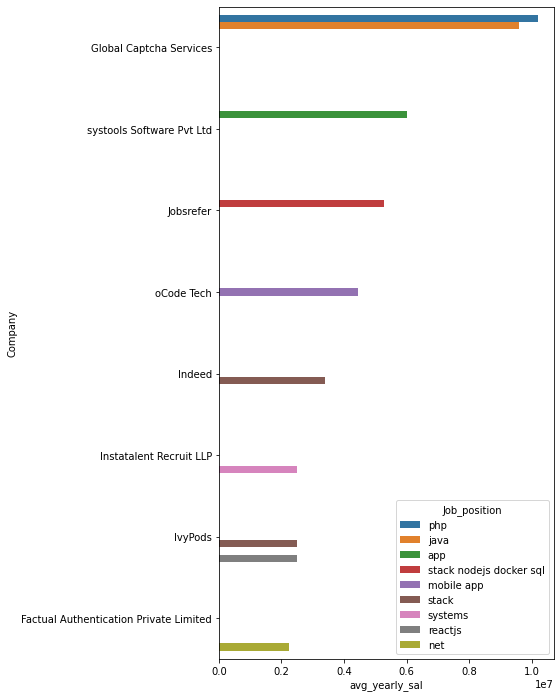

In [29]:
plt.figure(figsize=(6,12))
sns.barplot(y = 'Company', x='avg_yearly_sal', data=top_10, hue='Job_position')

<AxesSubplot:xlabel='Frequency', ylabel='skills'>

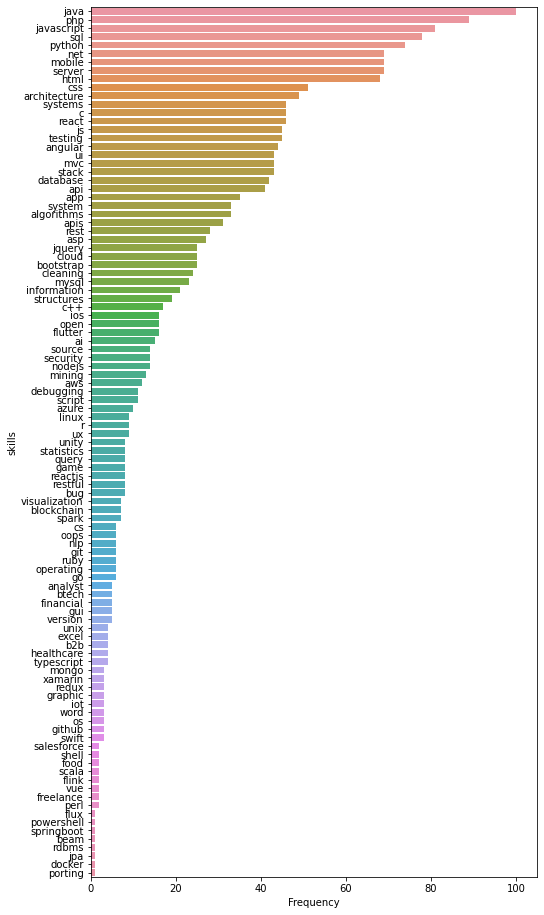

In [30]:
plt.figure(figsize=(8,16))
sns.barplot(x='Frequency', y='skills', data=skill_df[['skills', 'Frequency']].sort_values(by=['Frequency'], ascending=False))

Above is the plot of frequency of a particular skill ocurring in requirements column

Now lets look at it differently 

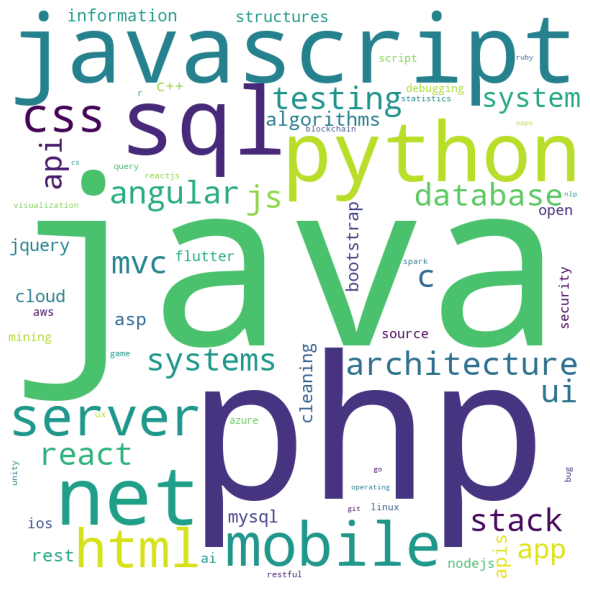

In [31]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(skills_dict) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From the wordcloud we can see some of the trending skills in software industry<br>
Looks like most jobs are for front end, most popular framework is .net and the most asked for programming language is python, php and java     

In [32]:
df[['Job_position', 'avg_yearly_sal']].sort_values(by=['avg_yearly_sal'], ascending=False)

,Job_position,avg_yearly_sal
1700,php,10200000.0
2234,java,9600000.0
593,app,6000000.0
1819,na,5500000.0
2703,na,5500000.0
...,...,...
1883,html,0.0
1882,na,0.0
1880,python,0.0
1879,angular,0.0


Now lets look at <b>average salary</b> wrt to <b>job role</b>

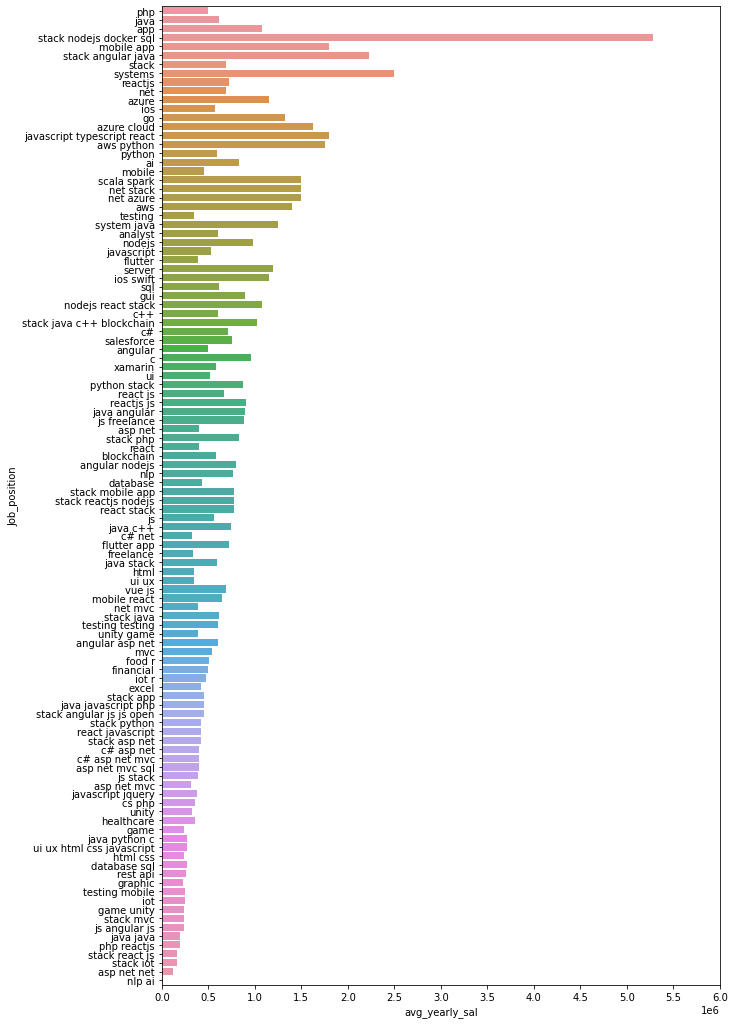

In [33]:
plt.figure(figsize = (10,18))
sns.barplot(y = 'Job_position', x = 'avg_yearly_sal', data =  df.loc[(df['avg_yearly_sal'] != 0) & (df['Job_position'] != 'na')].sort_values(by=['avg_yearly_sal'], ascending=False), ci=False)
plt.xticks([0, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6, 3.5e6, 4e6, 4.5e6, 5e6, 5.5e6, 6e6])
plt.show()

(i)   Most salaries are below Rs.50000 <br>
(ii)  The highest offered salary is of Rs.5285450 by Jobsrefer<br> 
(iii) A Company even pays an annual salary of just Rs. 6500 !!

In [34]:
df.iloc[df['avg_yearly_sal'].argmax()][['Company', 'avg_yearly_sal']]

Company           Global Captcha Services
avg_yearly_sal                 10200000.0
Name: 1700, dtype: object

In [35]:
sal_df = df[df['avg_yearly_sal']>0] 
sal_df.iloc[sal_df['avg_yearly_sal'].argmin()][['Company', 'avg_yearly_sal']]

Company           Indiafin Technologies Ltd
avg_yearly_sal                       6500.0
Name: 14, dtype: object

Now lets look at the top 20 companies paying highest annual salaries wrt state 

In [36]:
top_company_sal = pd.pivot_table(df, index=['Company', 'job_title', 'State'], values=['avg_yearly_sal']).sort_values('avg_yearly_sal', ascending=False)[:20]
top_company_sal.reset_index(inplace=True)

<AxesSubplot:xlabel='avg_yearly_sal', ylabel='Company'>

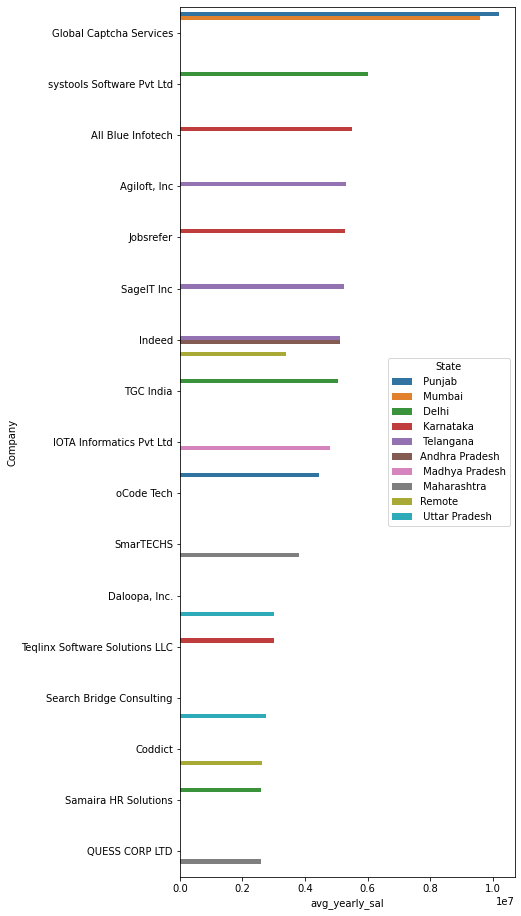

In [37]:
plt.figure(figsize=(6,16))
sns.barplot(y = 'Company', x = 'avg_yearly_sal', data=top_company_sal, ci=False, hue='State')

Looks like most of the high paying companies are based in Karnatka, followed by Delhi

<AxesSubplot:xlabel='avg_yearly_sal', ylabel='Company'>

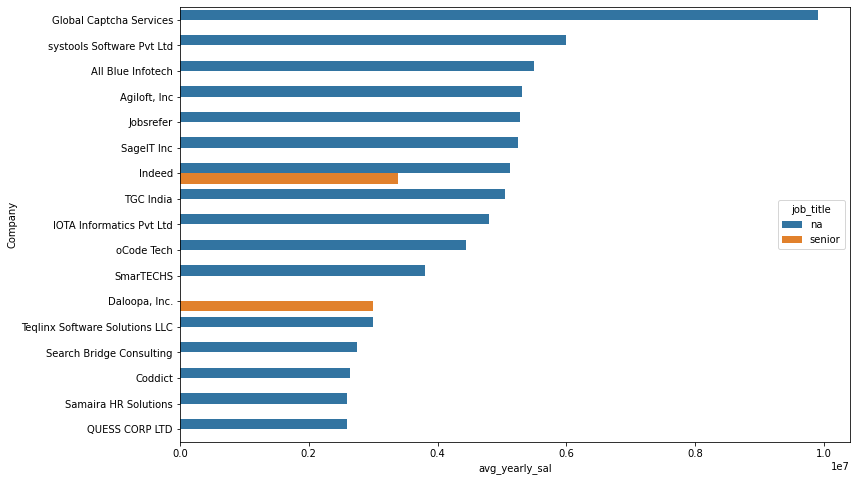

In [38]:
plt.figure(figsize=(12,8))
sns.barplot(y = 'Company', x = 'avg_yearly_sal', data=top_company_sal, hue='job_title', ci=False)

As expected Companies offer high paying salries to senior employees <br>
Looks like most of the missing <b>job_titles</b> for above companies are probably senior <br>
Suprisingly most of popular companies like Accenture, JP Morgan, Siemens etc. are nowhere near the top 

In [39]:
df_pivots = df[['python', 'stack', 'java', 'react', 'apis',
               'c', 'net', 'mvc', 'mobile', 'testing', 'sql', 'css', 'server',
               'database', 'html', 'ui', 'system', 'php', 'angular', 'systems', 'app',
               'javascript', 'rest', 'api', 'js', 'cleaning', 'algorithms',
               'architecture', 'information', 'jquery']]

Lets look at effect of skills on annual salary

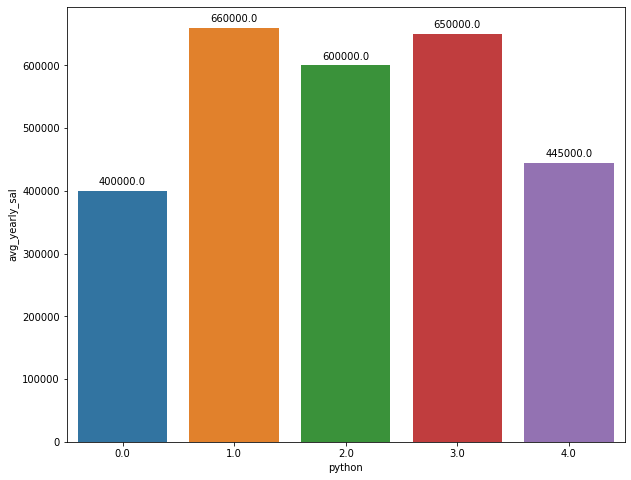

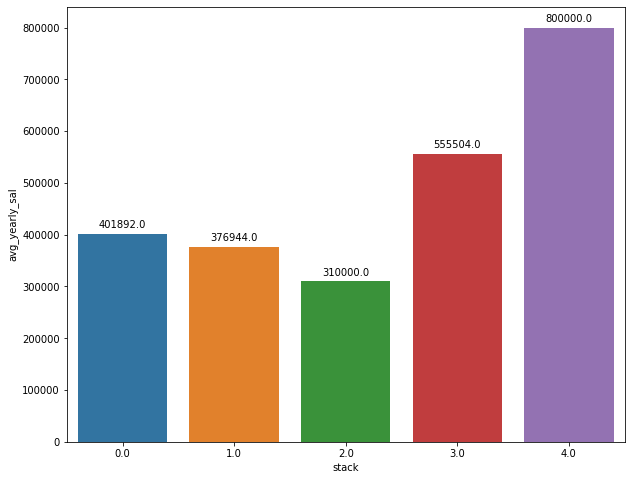

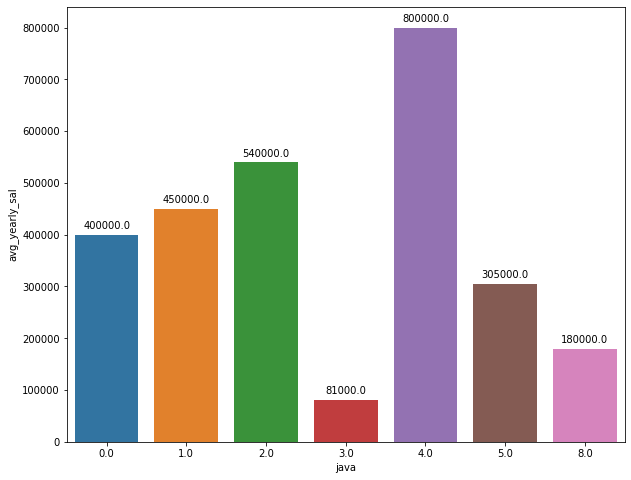

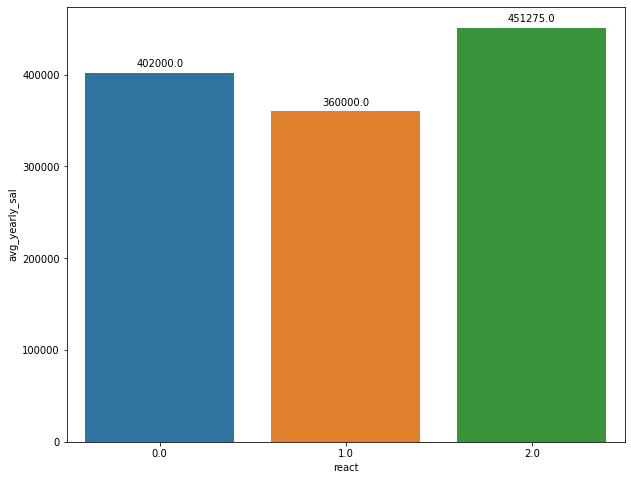

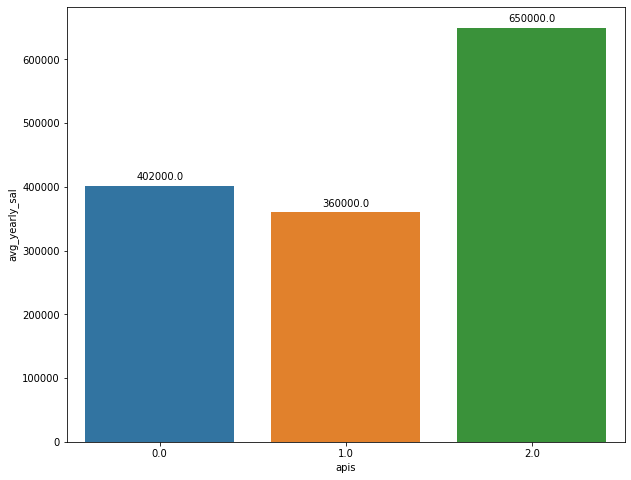

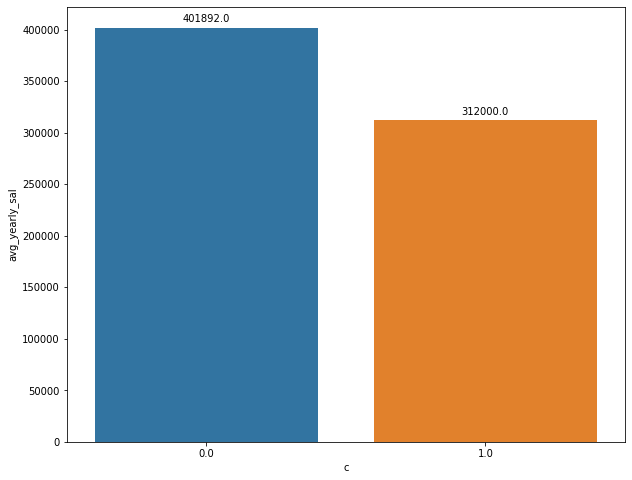

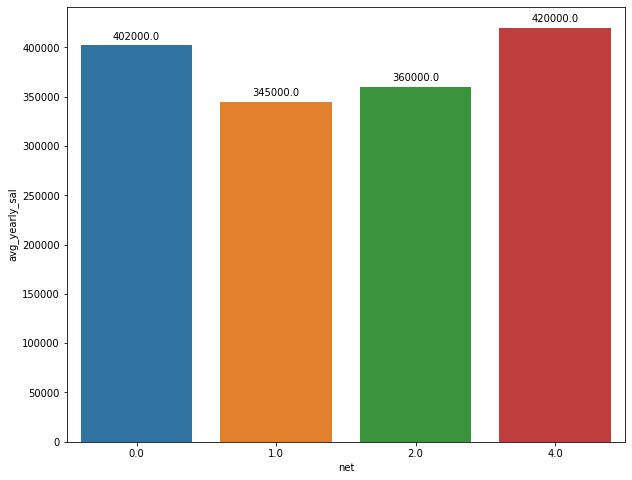

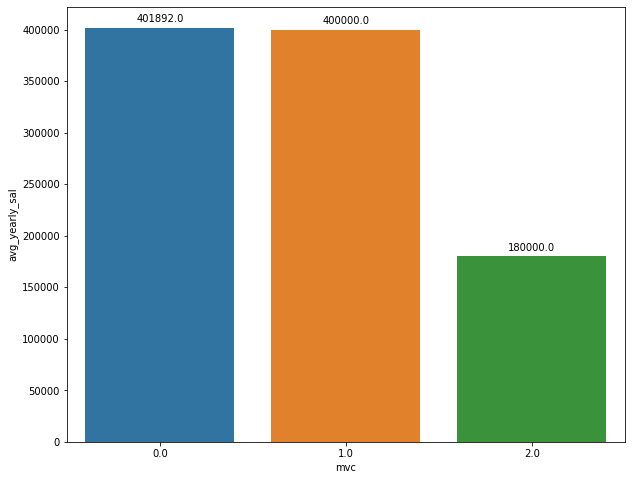

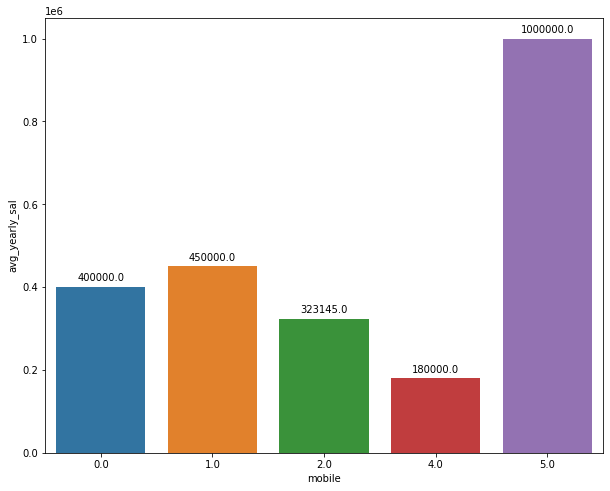

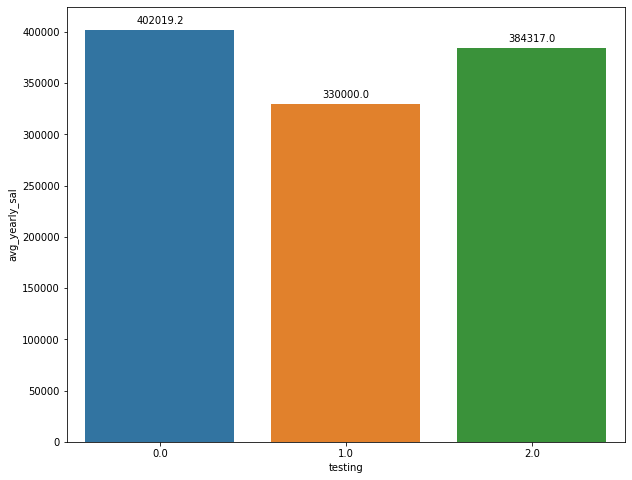

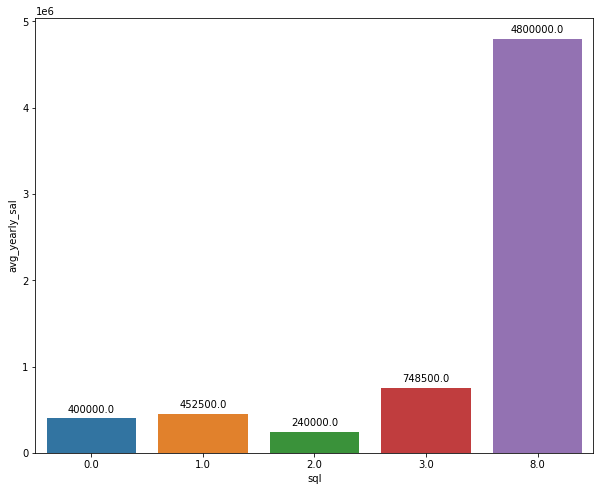

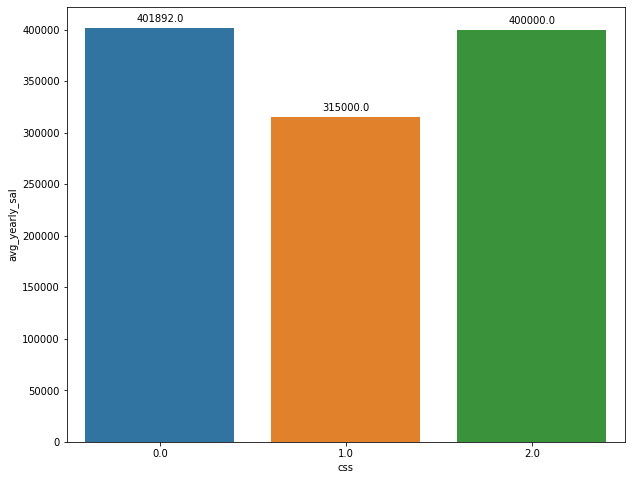

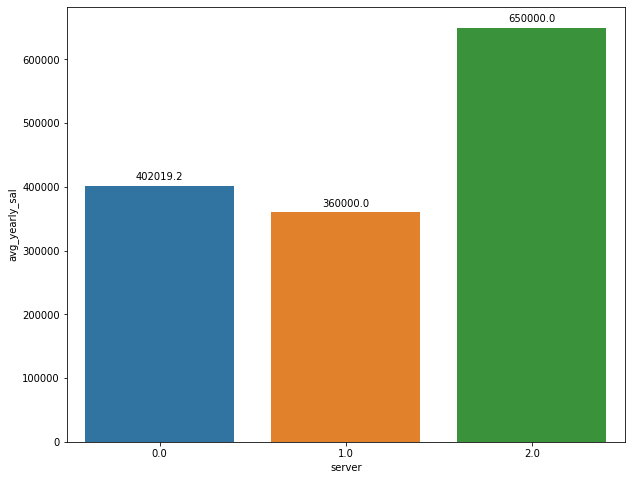

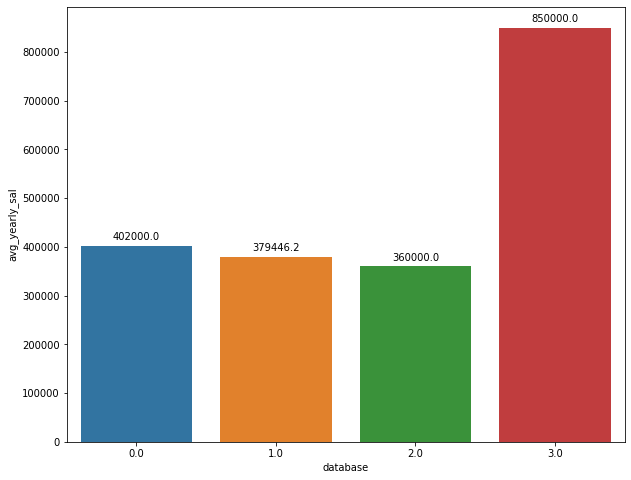

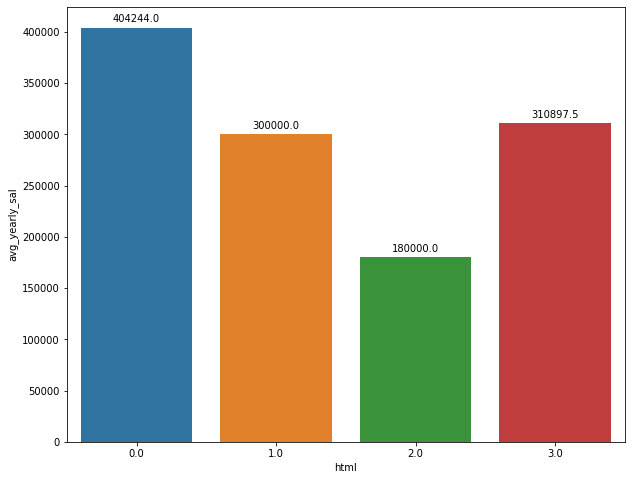

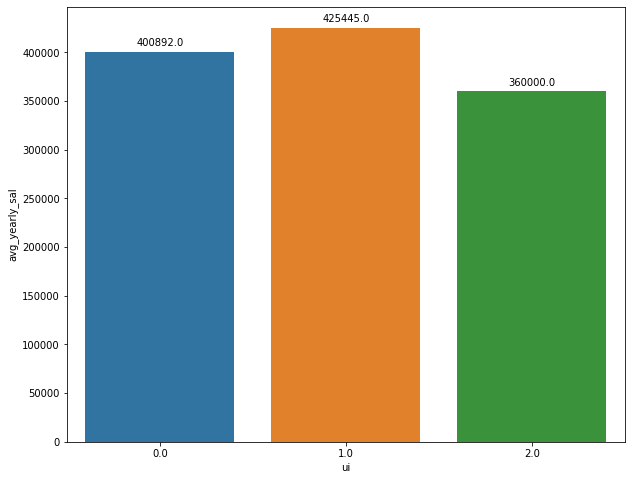

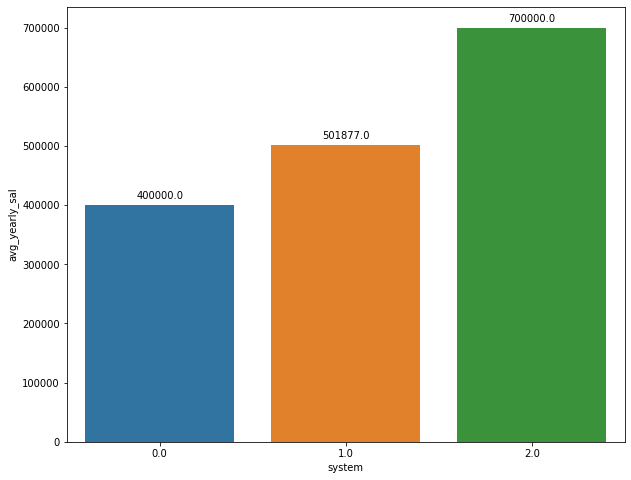

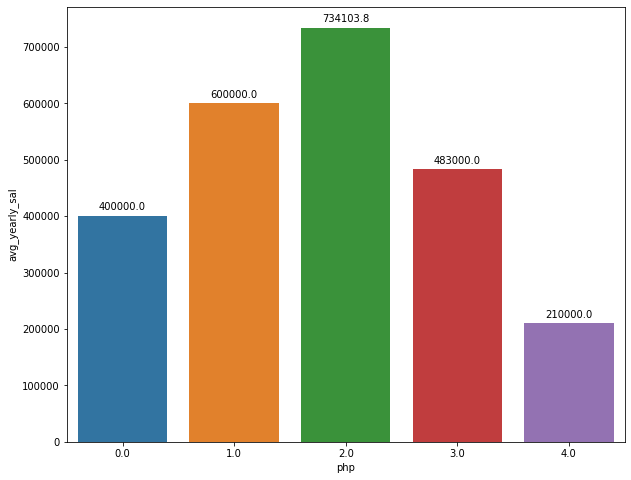

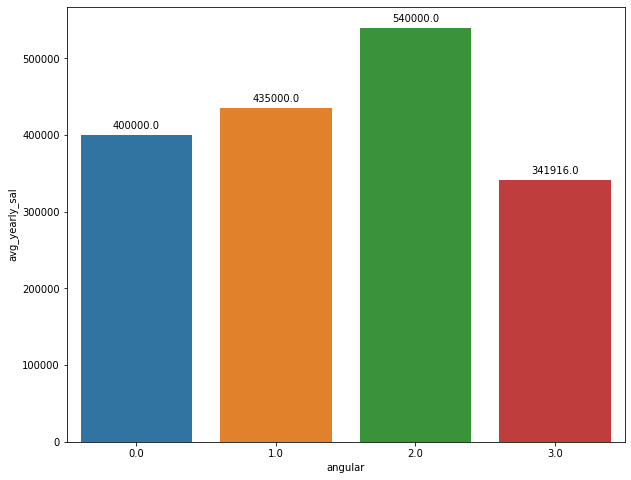

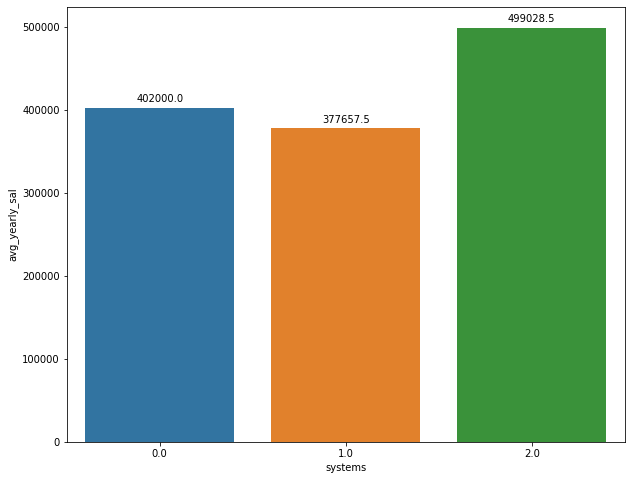

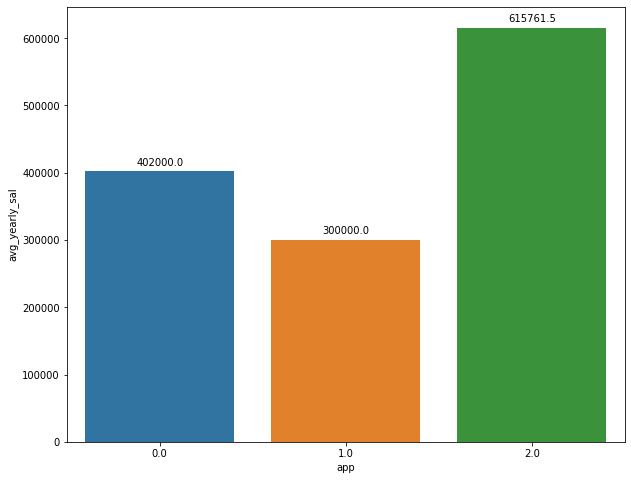

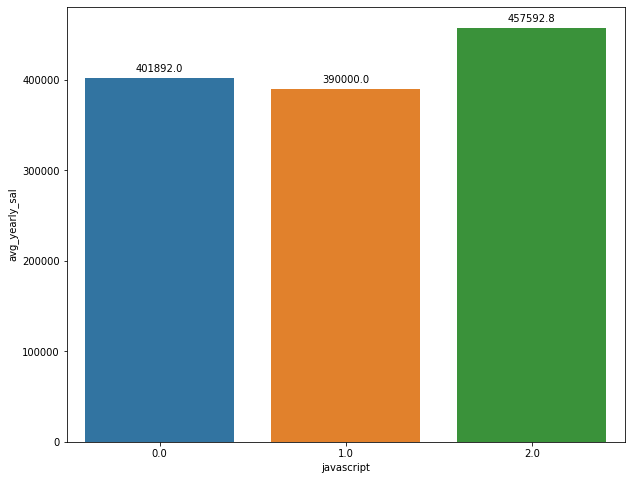

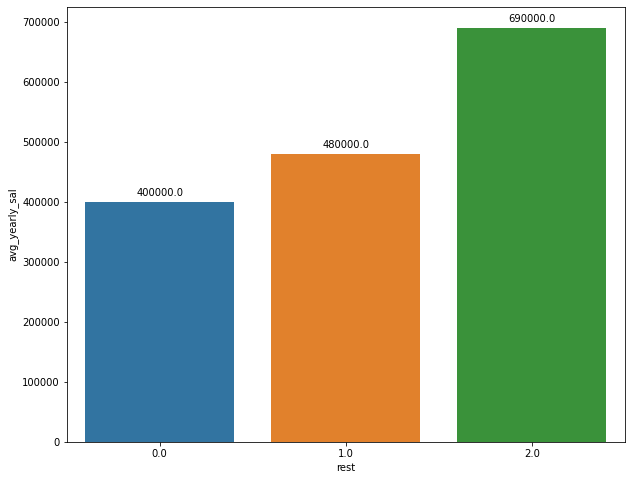

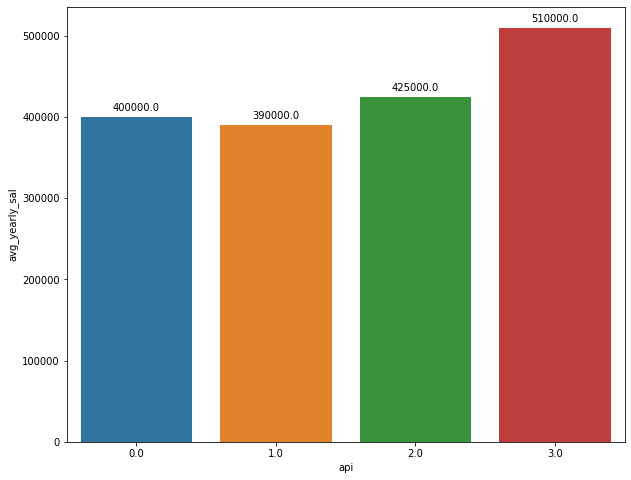

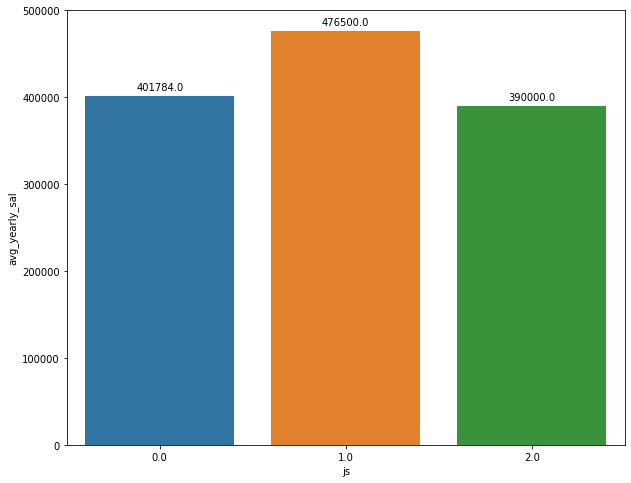

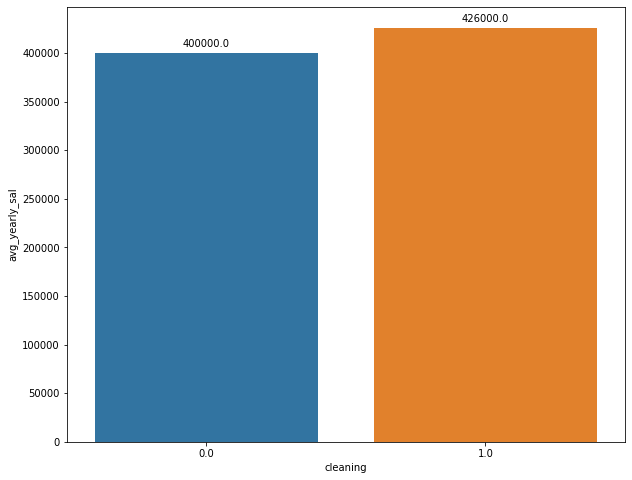

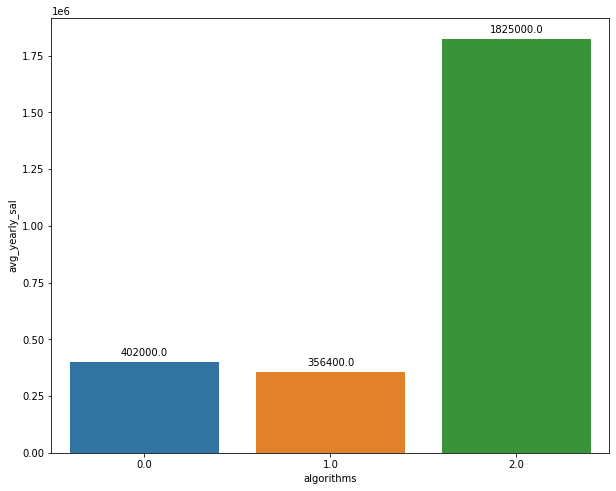

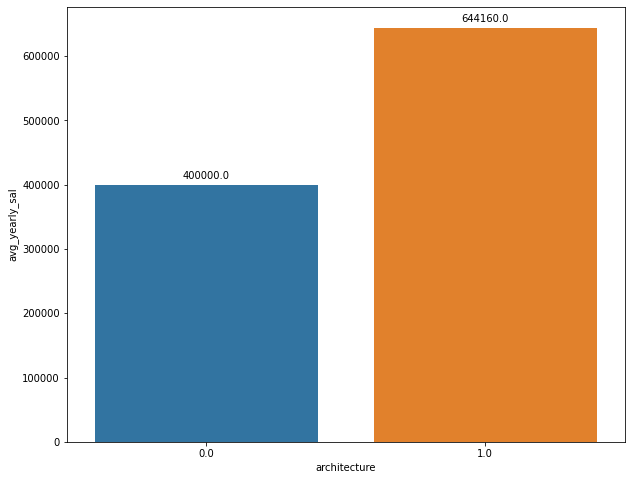

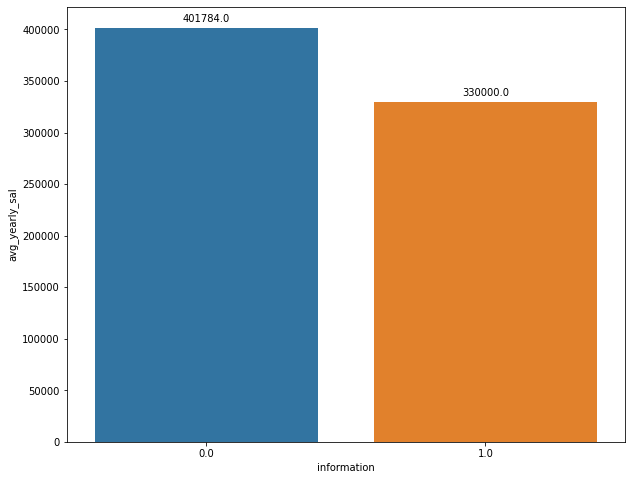

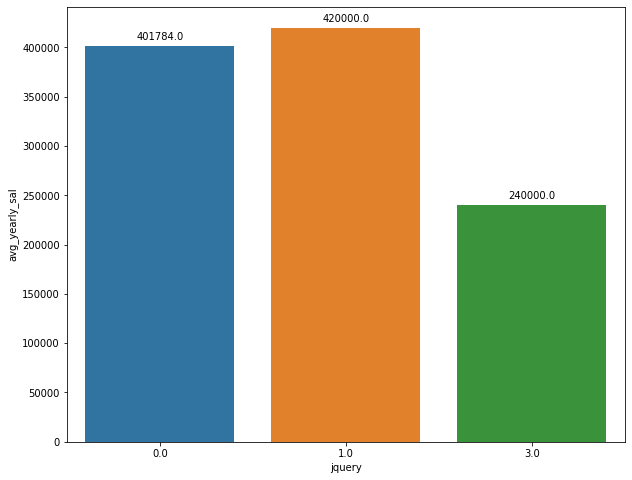

In [40]:
for i in df_pivots.columns:
    if i != 'avg_yearly_sal':
        splot = sns.barplot(x = i, y='avg_yearly_sal', data=df[df['avg_yearly_sal'] != 0], ci=False, estimator=np.median)  
        for p in splot.patches:
                   splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
        plt.show(block=False)                                         # So plot dont overwrite when print them 

<b>Skills for which companies pay higher : </b>  <br>
(i) python, java, .net, mvc, mobile, testing, sql, css, database, ui, system, php, app, javascript, algos, architecture  <br> <br>
Skills you must have in your cv   :)

<b>Skills for which companies pay less compared to other skills : </b>  <br>
(ii) stack, bootstrap, react, C, server, html, angular, systems, rest, cleaning, information, jquery 

(iii) Skills like java, ux, food, ios, aws are payed equally compared with others

Now we are going to do 2 things:<br>
(i) We will calculate rating on the basis of income category and fill missing ratings where income category is present but rating is missing <br> 
(ii) We will calculate the median of average yearly salaries on the basis of ratings and fill those entries where we have ratings but not salary<br>

<b>Note</b>: <br>
We calculate ratings before because we impute average year salary in the next step and dont want ratings to be calculated with imputed salaries but with orignal available salaries  

In [41]:
rating_freq = pd.pivot_table(df[(df['rating'] > 0) & (df['avg_yearly_sal'] != 0)], index='income_cat', values='rating')

In [42]:
freq = df[(df['rating'] > 0) & (df['avg_yearly_sal'] != 0)].groupby('rating')['avg_yearly_sal'].median()

In [43]:
x = df[(df['rating']>0) & (df['avg_yearly_sal'] == 0)]['rating'].map(freq)
count=0
for i in x.index:
    df.loc[i, 'avg_yearly_sal'] = x.values[count]
    count += 1
df['avg_yearly_sal'] = df['avg_yearly_sal'].fillna(0)

Filling missing ratings on the basis of income_category

In [44]:
for i in df[(df['rating'] == 0) & (df['avg_yearly_sal'] != 0)].index:
    if df.loc[i, 'income_cat'] == 2:
        df.loc[i, 'rating'] = 3.7
    
    if df.loc[i, 'income_cat'] == 3:
        df.loc[i, 'rating'] = 3.88
    
    if df.loc[i, 'income_cat'] == 4:
        df.loc[i, 'rating'] = 3.4
        
    if df.loc[i, 'income_cat'] == 5:
        df.loc[i, 'rating'] = 3.9
    
    if df.loc[i, 'income_cat'] == 6:
        df.loc[i, 'rating'] = 4.4

We want to train our models on the available yearly salaries only, lets filter them out

In [45]:
df = df[df['avg_yearly_sal'] > 0]

In [46]:
df = df.drop('income_cat', axis=1)

In [47]:
df.head()

,Job_position,Company,Location,requirements,rating,experience,posting_frequency,avg_yearly_sal,net_experience,education_level,...,algorithms,architecture,source,information,bootstrap,mysql,debugging,restful,apis,linux
0,na,Gather Network,"Urban Estate Gurgaon, Haryana",blockchain,3.88,na,1.0,240000.0,0,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,na,Agile Placement,"Pune, Maharashtra",java spark python r,3.40,Total work: 6 years,1.0,950000.0,6,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,na,Client of PlaceElements HR,"Thiruvananthapuram, Kerala",NaN,3.40,Python: Algorithms: Statistics: 1 yearData Sci...,1.0,750000.0,2,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,na,Siemens Technology and Services Private Limited,"Pune, Maharashtra",c++,4.00,na,2.0,561000.0,-99,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,na,Teqlinx Software Solutions LLC,"Bengaluru, Karnataka",structures,4.40,na,1.0,3000000.0,-99,na,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
#df.to_csv('./data/data_for_modelling_check.csv', index=False)